# Development Notebook

This notebook will be used to develop various snippets of code to model a battery energy storage system. 

In [2]:
# By convention, PyPSA is imported without an alias:
import pypsa

# Other dependencies
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import holoviews as hv
import hvplot.pandas
import cartopy.crs as ccrs
import folium
import mapclassify
from pypsa.plot.maps.static import (
    add_legend_circles,
    add_legend_patches,
    add_legend_lines,
)
from pathlib import Path
import numpy as np
import plotly.express as px
from datetime import datetime

import requests
from io import BytesIO
from zipfile import ZipFile
import time
import os

import pyomo.environ as pyo
import numpy_financial as npf
from statsmodels.tsa.statespace.sarimax import SARIMAX


import matplotlib
from matplotlib.ticker import PercentFormatter, StrMethodFormatter

# plt.style.use("bmh")

In [3]:
# Set styles
plt.style.use('seaborn-v0_8')
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rc('axes', labelsize=18)
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('lines', linewidth=3)

### Pulling data from CAISO

CAISO uses what appears to be a self-built tool called OASIS to allow easy access to their data. 

A few notes on pulling data from OASIS: 
* Only the last 39 months of data is stored
* Data can be pulled in either XML format or CSV format (CSV requires adding resultformat=6)
* When an error is returned, it's returned as XML. This is why the script has to be able to read both XML and CSV
* I have found that it's best to pull data in 1-week chunks. Others have done monthly, I believe. 
* You will get error 429 (too many requests) if you try to pull data too quickly. I found a 5 second interval was sufficient. 

If you want more than 39 months, it appears that you need to buy access through a service that has archived the data. I haven't explored this in depth yet. 


In [ ]:


def is_xml_file(raw_bytes):
    """Detect whether a file is XML."""

    start = raw_bytes[:20].lstrip()
    return start.startswith(b'<?xml') or start.startswith(b'<')


def _strip_ns(tag):
    """Remove XML namespace from tag."""
    return tag.split("}", 1)[-1] if "}" in tag else tag

def xml_contains_error(raw_bytes):
    """Return True if XML contains an <ERROR> block. Note that test data had the header <m:ERROR>,
    which is why we check for just ERROR> and not <ERROR>"""
    return b"ERROR>" in raw_bytes or b"ERR_CODE>" in raw_bytes

def parse_oasis_error_xml(raw_bytes):
    """Extract ERR_CODE and ERR_DESC from an OASIS error XML."""
    root = ET.fromstring(raw_bytes)
    err_code = None
    err_desc = None

    for elem in root.iter():
        tag = _strip_ns(elem.tag).upper()
        if tag == "ERR_CODE":
            err_code = elem.text
        elif tag == "ERR_DESC":
            err_desc = elem.text

    return err_code, err_desc


def parse_oasis_xml(raw_bytes):
    """Parse OASIS XML that contains REPORT_DATA rows."""
    root = ET.fromstring(raw_bytes)

    # Find all REPORT_DATA elements regardless of namespace
    report_rows = [
        elem for elem in root.iter()
        if _strip_ns(elem.tag).upper() == "REPORT_DATA"
    ]

    if not report_rows:
        raise ValueError("XML contains no REPORT_DATA elements.")

    rows = []
    for rpt in report_rows:
        row = {}
        for child in rpt:
            key = _strip_ns(child.tag).upper()
            row[key] = (child.text or "").strip()
        rows.append(row)

    return pd.DataFrame(rows)

def read_oasis_zip(response_bytes):
    """Read all CSV or XML files inside an OASIS ZIP response."""
    dfs = []

    with ZipFile(BytesIO(response_bytes)) as z:
        for fname in z.namelist():
            if not fname.lower().endswith((".csv", ".xml")):
                continue

            with z.open(fname) as f:
                raw = f.read()

            # XML case
            if is_xml_file(raw):
                if xml_contains_error(raw):
                    # Log the error
                    code, desc = parse_oasis_error_xml(raw)
                    print(f"[OASIS ERROR] File: {fname} | Code: {code} | Desc: {desc}")
                    continue  # Skip this file

                # Valid XML with data
                try:
                    df = parse_oasis_xml(raw)
                except Exception as e:
                    print(f"[XML PARSE ERROR] {fname}: {e}")
                    continue

            # CSV case
            else:
                try:
                    df = pd.read_csv(BytesIO(raw))
                except Exception as e:
                    print(f"[CSV PARSE ERROR] {fname}: {e}")
                    continue

            dfs.append(df)

    if not dfs:
        print("[WARN] No usable data found in ZIP.")
        return pd.DataFrame()

    return pd.concat(dfs, ignore_index=True)


def fetch_caiso_week(node, start_date, end_date):
    """
    Fetch CAISO day-ahead nodal LMPs from OASIS and normalize schema. Only tested on weekly timeframes. Breaks under longer timeframes. 

    Parameters
    ----------
    node : str
        CAISO PNode name, e.g. "TH_N001"
    start_date : str
        Start datetime in format YYYYMMDDT00:00-0000
    end_date : str
        End datetime in format YYYYMMDDT00:00-0000

    Returns
    -------
    pandas.DataFrame
        Tidy dataframe with columns:
        interval_start, node, LMP, MCE, MCC, MCL
    """

    # node = "119TH_BP_LNODEXF1"
    # start_date = "20251206T00:00-0000"
    # end_date   = "20251207T00:00-0000"

    base_url = "http://oasis.caiso.com/oasisapi/SingleZip"

    params = {
        "queryname": "PRC_LMP",
        "market_run_id": "DAM",
        "node": node,
        "startdatetime": start_date,
        "enddatetime": end_date,
        "resultformat": 6,  # Produces CSV instead of XML
        "version": 12  # Confirmed to work with v12; not sure about others
    }

    print(f"Requesting data for node {node}...")
    response = requests.get(base_url, params=params)

    if response.status_code != 200:
        raise RuntimeError(f"Failed request: {response.status_code}")

    # Unzip the returned file
    df = read_oasis_zip(response.content)

    if len(df) == 0:
        return pd.DataFrame()

    # Normalize column names
    df.columns = df.columns.str.upper()

    # Detect schema
    schema_a = "LMP" in df.columns  # older schema
    schema_b = "MW" in df.columns   # newer schema

    if schema_a:
        # Schema A: LMP, MCE, MCC, MCL already present
        df["VALUE"] = df["LMP"]

    elif schema_b:
        # Schema B: MW column contains the numeric value
        df["VALUE"] = df["MW"]

    else:
        raise ValueError("Unrecognized CAISO PRC_LMP schema. No LMP or MW column found.")

    # Standardize timestamp column names
    time_cols = [c for c in df.columns if "INTERVALSTART" in c]
    if time_cols:
        df["INTERVAL_START"] = pd.to_datetime(df[time_cols[0]])
    else:
        raise ValueError("Could not find interval start time column.")

    # Standardize node column
    if "NODE" not in df.columns:
        raise ValueError("NODE column missing from PRC_LMP file.")

    # Pivot into wide format
    df_pivot = df.pivot_table(
        index=["INTERVAL_START", "NODE"],
        columns="LMP_TYPE",
        values="VALUE"
    ).reset_index()

    # Ensure all expected columns exist
    for col in ["LMP", "MCE", "MCC", "MCL"]:
        if col not in df_pivot.columns:
            df_pivot[col] = None

    return df_pivot

def get_historical_caiso_lmp(node, start_date, end_date, sleep_time=5, periodic_save=False, fpath=""):
    """
    Fetch CAISO historical day-ahead nodal LMPs from OASIS and normalize schema. Only tested on weekly timeframes. Breaks under longer timeframes. 

    Parameters
    ----------
    node : str
        CAISO PNode name, e.g. "TH_N001"
    start_date : str
        Start datetime in format YYYYMMDDT00:00-0000
    end_date : str
        End datetime in format YYYYMMDDT00:00-0000
    sleep_time : int, optional
        Time to sleep between API calls to avoid hitting the rate limit. Default is 5 seconds.

    Returns
    -------
    pandas.DataFrame
        Tidy dataframe with columns:
        interval_start, node, LMP, MCE, MCC, MCL
    """

    # Break the date range into weekly chunks. 
    # This is necessary because the CAISO API has a limit on the number of days that can be requested at once.

    if (pd.Timestamp(end_date) - pd.Timestamp(start_date)) > pd.Timedelta(weeks=1):

        weekly_data = []

        # Construct range of dates
        date_range = pd.date_range(start=start_date, end=end_date, freq="W")

        if date_range[0] != pd.Timestamp(start_date):
            weekly_data.append(fetch_caiso_week(node, start_date, date_range[0].strftime("%Y%m%dT00:00-0000")))

        for i in range(len(date_range) - 1):
            time.sleep(sleep_time)  # Sleep for a second to avoid hitting the API rate limit

            start_week = date_range[i].strftime("%Y%m%dT00:00-0000")
            end_week = date_range[i + 1].strftime("%Y%m%dT00:00-0000")

            weekly_data.append(fetch_caiso_week(node, start_week, end_week))

            if periodic_save: 
                # Save the data periodically to avoid losing it in case of a crash
                intermediate_df = pd.concat(weekly_data, ignore_index=True)
                intermediate_df.to_csv(os.path.join(fpath, f"intermediate_{node}_LMP_data.csv"), index=False)
        
        if date_range[-1] != pd.Timestamp(end_date):
            time.sleep(sleep_time)  # Sleep for a second to avoid hitting the API rate limit
            weekly_data.append(fetch_caiso_week(node, date_range[-1].strftime("%Y%m%dT00:00-0000"), end_date))

        # Concatenate all the weekly data into a single dataframe
        df_historical = pd.concat(weekly_data, ignore_index=True)

    else: 
        df_historical = fetch_caiso_week(node, start_date, end_date)

    return df_historical



### Grab data for the DLAP node 
node = "TH_NP15_GEN-APND"
start = "20221201T00:00-0000"
end   = "20251201T00:00-0000"

# start = "20250101T00:00-0000"
# end   = "20250115T00:00-0000"

folderpath = r"C:\Users\jpsta\data\grid_data"

# LMP_data = fetch_caiso_week(node, start, end)


# Uncomment to grab data from CAISO
# LMP_data = get_historical_caiso_lmp(node, start, end, sleep_time=10, periodic_save=True, fpath=folderpath)
# LMP_data.to_csv(os.path.join(folderpath, f"{node}_LMP_{start[:11]}-{end[:11]}.csv"), index=False)

# Uncomment to load data from CSV (you may need to get the name manually)
fpath = r"C:\Users\jpsta\data\grid_data\TH_NP15_GEN-APND_LMP_20221201T00-20251201T00.csv"
LMP_data = pd.read_csv(fpath, parse_dates=["INTERVAL_START"])
print(LMP_data.head())


             INTERVAL_START              NODE        LMP      MCC        MCE  \
0 2022-12-01 00:00:00+00:00  TH_NP15_GEN-APND  155.00000  0.00000  155.00000   
1 2022-12-01 01:00:00+00:00  TH_NP15_GEN-APND  183.91872 -0.00128  183.92000   
2 2022-12-01 02:00:00+00:00  TH_NP15_GEN-APND  160.70000 -0.00116  160.70116   
3 2022-12-01 03:00:00+00:00  TH_NP15_GEN-APND  157.13779 -0.49222  157.63000   
4 2022-12-01 04:00:00+00:00  TH_NP15_GEN-APND  151.51282 -0.48119  151.99400   

   MCL  MGHG  
0  0.0   0.0  
1  0.0   0.0  
2  0.0   0.0  
3  0.0   0.0  
4  0.0   0.0  


In [15]:
# Generate a rough forecast of future prices based on historical data. 

def generate_synthetic_prices(
    y,
    years_out=20,
    noise_std=0.05,
    shuffle=True,
    weekly_bootstrap=False,
    seed=42
):
    """
    Generate a long-horizon synthetic electricity price series by repeating,
    shuffling, and lightly perturbing a historical dataset.

    Parameters
    ----------
    y : pandas.Series
        Hourly historical price series with a proper datetime index.
        Should cover at least ~3 years for good seasonal structure.
    years_out : int, default 20
        Number of years to generate.
    noise_std : float, default 0.05
        Standard deviation of multiplicative noise applied to each hour.
        Example: 0.05 = ±5% noise.
    shuffle : bool, default True
        If True, randomly shuffle the order of historical years.
    weekly_bootstrap : bool, default False
        If True, randomly sample weeks instead of whole years.
        Produces more diversity but slightly less structural fidelity.
    seed : int, default 42
        Random seed for reproducibility.

    Returns
    -------
    synthetic : pandas.Series
        A synthetic hourly price series of length `years_out` years,
        with realistic seasonality and mild stochastic variation.
    """

    np.random.seed(seed)

    # Ensure hourly frequency
    y = y.sort_index()
    y = y.asfreq("H")

    # Extract year boundaries
    years = sorted(y.index.year.unique())
    n_hist_years = len(years)

    if n_hist_years < 2:
        raise ValueError("Need at least 2 years of historical data.")

    # --- STEP 1: Break into chunks ---
    if weekly_bootstrap:
        # Break into weekly chunks
        weekly_groups = list(y.groupby([y.index.year, y.index.isocalendar().week]))
        chunks = [g[1] for g in weekly_groups]
    else:
        # Break into yearly chunks
        chunks = [y[y.index.year == yr] for yr in years]

    # --- STEP 2: Shuffle chunks ---
    if shuffle:
        np.random.shuffle(chunks)

    # --- STEP 3: Repeat chunks until we reach desired length ---
    needed_chunks = int(np.ceil(years_out / n_hist_years)) * len(chunks)
    repeated_chunks = chunks * int(np.ceil(needed_chunks / len(chunks)))

    # Concatenate and trim
    synthetic = pd.concat(repeated_chunks)
    synthetic = synthetic.iloc[: years_out * 365 * 24]

    # --- STEP 4: Add mild multiplicative noise ---
    noise = np.random.normal(loc=1.0, scale=noise_std, size=len(synthetic))
    synthetic = synthetic * noise

    # --- STEP 5: Fix index to be continuous hourly timestamps ---
    start = y.index[0]
    synthetic.index = pd.date_range(start=start, periods=len(synthetic), freq="H")

    return synthetic


LMP_data_long = generate_synthetic_prices(LMP_data.set_index('INTERVAL_START')['LMP'], years_out=20)
LMP_data_long = LMP_data_long.reset_index().rename(columns={'index': 'INTERVAL_START'})

folderpath = r"C:\Users\jpsta\data\grid_data"
LMP_data_long.to_csv(os.path.join(folderpath, "long_LMP.csv"))

C:\Users\jpsta\AppData\Local\Temp\ipykernel_46496\2187587366.py:44: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\jpsta\AppData\Local\Temp\ipykernel_46496\2187587366.py:80: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



Text(0.5, 1.0, 'LMP for TH_NP15_GEN-APND from 2022-12-01 to 2037-12-01')

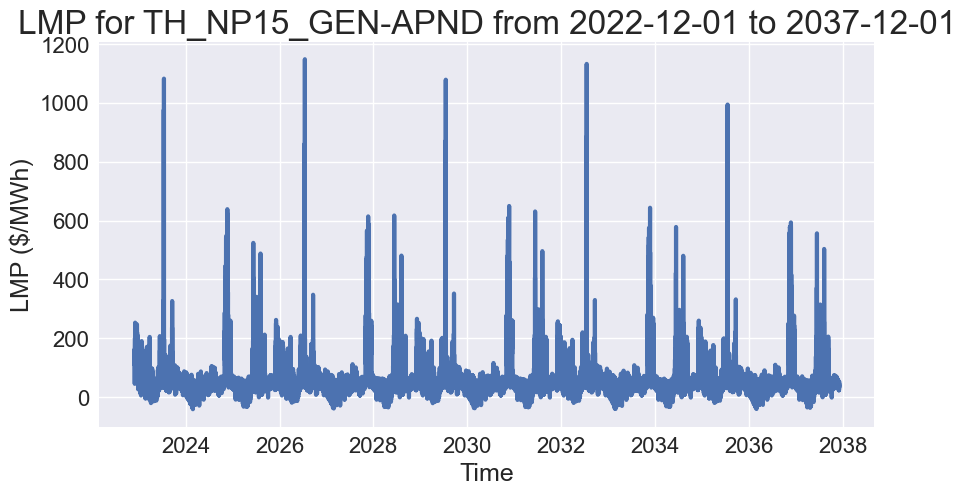

In [ ]:
# Sanity check data 

LMP_small = LMP_data.iloc[:24*7,:]



plt.figure(figsize=(10, 5))
plt.plot(LMP_data_long['INTERVAL_START'], LMP_data_long['LMP'])
plt.xlabel('Time')
plt.ylabel('LMP ($/MWh)')
plt.title(f'LMP for {node} from 2022-12-01 to 2037-12-01')

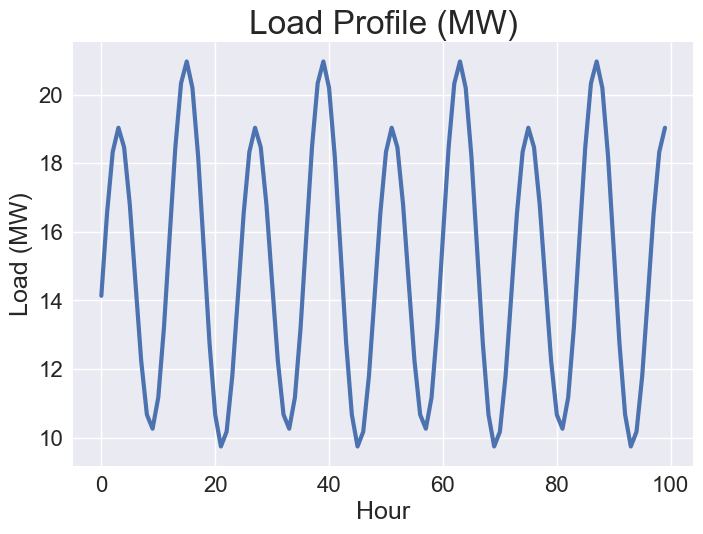

In [20]:
# Now it's time to come up with the load profile! It's not actually constant. 
# I couldn't find a good source for a realistic datacenter load profile, but I did see 
# a couple sources saying it's fairly constant with some variation based on cooling load. 

# Assume hourly data

load_IT_const = 15  # MW
load_IT_variation = 5  # MW (this will vary sinusoidally)
load_cooling = 1  # MW (this will peak in the middle of the day)

num_steps = len(LMP_data_long)
x = np.arange(num_steps)

load_profile = np.ones(num_steps) * load_IT_const + load_IT_variation * np.sin(4 * np.pi * x / 24) + load_cooling * np.sin(2 * np.pi * (x - 8) / 24)  # Base load in MW

# Plot the first 100 hours of the load profile to see what it looks like
plt.plot(range(100), load_profile[:100])
plt.title('Load Profile (MW)')
plt.xlabel('Hour')
plt.ylabel('Load (MW)')

load_df = pd.DataFrame({'INTERVAL_START': LMP_data_long['INTERVAL_START'], 'load': load_profile})
load_df.merge(LMP_data_long, on='INTERVAL_START').to_csv(os.path.join(folderpath, f"{node}_load_profile.csv"), index=False)

In [4]:
# Ok, it turns out that pypsa can't handle the LMP optimization. We'll need to do it live!

# Cut out inputs down to 7 days. 


Emax = 60  # MWh
hour_rating = 2  # Rated for 2 hours of storage
SOC_min = 0.1  # Minimum state of charge
SOC_max = 0.85  # Maximum state of charge\
SOC_available = SOC_max - SOC_min # Available state of charge
P_d_max = SOC_available * Emax / hour_rating
P_c_max = P_d_max
time_step = 1  # hour
eta_self = 0.0001  # Self-discharge rate per hour
eta_conv = 0.95  # Efficiency of converting AC electricity to DC energy within battery
starting_ending_SOC = 0.5  # Starting and ending state of charge


def battery_model(input_ts, input_scalar):


    # Create Model object
    m = pyo.ConcreteModel()

    # Set time steps
    m.t = pyo.Set(doc='Hour', initialize=range(len(input_ts)), ordered=True)

    # Define scalar parameters -- why do this? Mostly to keep the code functional if you pass the model to another namespace
    m.P_d_max = pyo.Param(initialize=input_scalar['Maximum Discharge (MW)'].iloc[0], doc='Max discharge power (MW)')
    m.P_c_max = pyo.Param(initialize=input_scalar['Maximum Charge (MW)'].iloc[0], doc='Max charge power (MW)')
    m.Emax = pyo.Param(initialize=input_scalar['Capacity (MWh)'].iloc[0], doc='Max energy (MWh)')
    m.SOC_min = pyo.Param(initialize=input_scalar['Minimum SOC'].iloc[0], doc='Min state of charge')
    m.SOC_max = pyo.Param(initialize=input_scalar['Maximum SOC'].iloc[0], doc='Max state of charge')
    m.delta_t = pyo.Param(initialize=input_scalar['Time Step (hours)'].iloc[0], doc='Time step (hours)')
    m.eta_conv = pyo.Param(initialize=input_scalar['One-Way Conversion Efficiency (%)'].iloc[0], doc='Battery conversion efficiency')
    m.eta_self = pyo.Param(initialize=input_scalar['Self-Discharge (%/hr)'].iloc[0], doc='Self-discharge rate per hour')

    # Time-dependent parameters
    m.LMP = pyo.Param(m.t, initialize=lambda m, t: input_ts['LMP'][t], doc='LMP (MW)')
    m.P_l = pyo.Param(m.t, initialize=lambda m, t: input_ts['load'][t], doc='Load (MW)')

    # Define variables

    m.P_d = pyo.Var(m.t, within=pyo.NonNegativeReals, doc='Discharge power (MW)')
    m.P_c = pyo.Var(m.t, within=pyo.NonNegativeReals, doc='Charge power (MW)')
    m.S = pyo.Var(m.t, within=pyo.NonNegativeReals, doc='State of charge')
    m.P_m = pyo.Var(m.t, within=pyo.Reals, doc='Net Power (MW)')
    m.u = pyo.Var(m.t, within=pyo.Binary, doc="Charging vs Discharging")

    # Set constraints

    def power_balance_rule(m, t):
        return m.P_m[t] == m.P_c[t] - m.P_d[t] + m.P_l[t]

    m.power_balance = pyo.Constraint(m.t, rule=power_balance_rule, doc='Power balance constraint')


    def storage_state_rule(m, t):
        if t == 0:
            return m.S[t] == starting_ending_SOC 
        else:
            return m.S[t] == m.S[t-1] * (1 - m.eta_self * m.delta_t) + m.delta_t / m.Emax * (m.P_c[t-1] * m.eta_conv - m.P_d[t-1] / m.eta_conv) 
        
    m.storage_state = pyo.Constraint(m.t, rule=storage_state_rule, doc='State of charge constraint')


    def storage_power_rule(m, t):
        return m.P_d[t] * m.delta_t <= m.Emax * m.S[t]
    m.storage_power = pyo.Constraint(m.t, rule=storage_power_rule, doc='Storage power constraint')


    def boundary_conditions_rule(m, t):
        if t == len(m.t) - 1:
            return m.S[t] == starting_ending_SOC
        else:
            return pyo.Constraint.Skip
        
    m.boundary_conditions = pyo.Constraint(m.t, rule=boundary_conditions_rule, doc='SOC boundary conditions constraint')

    def max_charge_power_rule(m, t):   
        return m.P_c[t] <= m.P_c_max * m.u[t]  # Charge when u=1
    m.max_charge_power = pyo.Constraint(m.t, rule=max_charge_power_rule, doc='Max charge power constraint')

    def max_discharge_power_rule(m, t):
        return m.P_d[t] <= m.P_d_max * (1 - m.u[t])  # Discharge when u = 0
    m.max_discharge_power = pyo.Constraint(m.t, rule=max_discharge_power_rule, doc='Max discharge power constraint')

    def soc_min_rule(m, t):
        return m.S[t] >= m.SOC_min
    m.soc_min = pyo.Constraint(m.t, rule=soc_min_rule, doc='Min SOC constraint')

    def soc_max_rule(m, t):
        return m.S[t] <= m.SOC_max
    m.soc_max = pyo.Constraint(m.t, rule=soc_max_rule, doc='Max SOC constraint')




    # Define objective function 
    m.objective = pyo.Objective(rule=lambda m: sum(m.LMP[t] * m.P_m[t] * m.delta_t for t in m.t), sense=pyo.minimize, doc='Cost Minimization')

    # Solve the model 
    solver = pyo.SolverFactory('appsi_highs')
    results = solver.solve(m, tee=True)
    return m, results


input_path = r'C:\Users\jpsta\code\energy-modeling\data\storage_model_inputs.xlsx'
input_ts = pd.read_excel(input_path, sheet_name='Time-Series Data', parse_dates=['INTERVAL_START'])
# input_ts['INTERVAL_START'] = input_ts['INTERVAL_START'].astype(pd.DateTimeIndex)
input_scalar = pd.read_excel(input_path, sheet_name='Scalar Parameters', skiprows=1)

m, results = battery_model(input_ts, input_scalar)


Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 1177 rows; 840 cols; 2518 nonzeros; 168 integer variables (168 binary)
Coefficient ranges:
  Matrix  [1e-02, 6e+01]
  Cost    [1e+02, 3e+02]
  Bound   [1e+00, 1e+00]
  RHS     [1e-01, 2e+01]
Presolving model
670 rows, 668 cols, 1668 nonzeros  0s
667 rows, 667 cols, 1666 nonzeros  0s
Presolve reductions: rows 667(-510); columns 667(-173); nonzeros 1666(-852) 

Solving MIP model with:
   667 rows
   667 cols (167 binary, 0 integer, 0 implied int., 500 continuous, 0 domain fixed)
   1666 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial upper; z => Trivial zero

        Nodes      |   

In [5]:
# Extract results

def extract_results(m, input_ts, finance_inputs):
    """
    Extract model outputs and compute financial performance metrics for a 
    battery storage dispatch simulation.

    This function pulls all Pyomo decision variables from a solved model,
    aligns them with the input time series, computes operating profit with 
    and without the battery, and evaluates discounted cash flows to produce 
    an NPV of operating profit over the simulation horizon.

    Parameters
    ----------
    m : pyomo.ConcreteModel
        A solved Pyomo model containing time-indexed decision variables 
        (e.g., charge/discharge power, SOC, net grid power).
    input_ts : pandas.DataFrame
        Time series inputs used in the model. Must contain:
        - 'INTERVAL_START' : datetime-like index or column
        - 'LMP'            : locational marginal price ($/MWh)
        - 'load'           : baseline load (MW)
    finance_inputs : pandas.DataFrame
        Financial parameters used for discounting. Must contain:
        - 'Real Discount Rate (%)'
        - 'Inflation Rate (%)'

    Returns
    -------
    df_results : pandas.DataFrame
        Hourly results including model variables, LMP, load, and profit 
        components. Columns include:
        - 'time (hours)'
        - 'LMP'
        - 'load'
        - 'Grid Power (MW)'
        - 'Charge Power (MW)'
        - 'Discharge Power (MW)'
        - 'SOC (%)'
        - 'profit'
        - 'no_battery_profit'
        - 'battery_profit'
    npv_op_profit : float
        Net present value of operating profit over the simulation horizon,
        discounted back to the first day of the simulation.
    daily_finances : pandas.DataFrame
        Daily aggregated battery profit and discounted profit, including:
        - 'battery_profit'
        - 'day_of_sim'
        - 'discounted_profit'

    Notes
    -----
    - Profit is computed as: -LMP * power * timestep.
    - Discounting is performed using a nominal discount rate derived from 
      real discount rate and inflation.
    - All discounting is relative to the first timestamp in `input_ts`.
    """

    model_vars = m.component_map(ctype=pyo.Var)
    df_results = pd.DataFrame({var.name: [var[t].value for t in m.t] for var in model_vars.values()})

    # Populate results df
    df_results['time (hours)'] = input_ts['INTERVAL_START']
    df_results['LMP'] = input_ts['LMP']  # Merge on time next time?
    df_results['load'] = input_ts['load']


    # Calculate profit
    df_results['profit'] = -1 * df_results['LMP'] * df_results['P_m'] * time_step
    df_results['no_battery_profit'] = -1 * df_results['LMP'] * df_results['load'] * time_step
    df_results['battery_profit'] = df_results['profit'] - df_results['no_battery_profit']
    df_results = df_results.rename(columns={
        'P_d': 'Discharge Power (MW)', 
        'P_c': 'Charge Power (MW)', 
        'S': 'SOC (%)', 
        'P_m': 'Grid Power (MW)'})


    # Add in discount rate
    real_discount_rate = finance_inputs['Real Discount Rate (%)'].iloc[0]  # Yearly opportunity cost of investing money into this project
    inflation_rate = finance_inputs['Inflation Rate (%)'].iloc[0]  # Yearly 
    nominal_discount_rate = (1 + real_discount_rate) * (1 + inflation_rate) - 1
    daily_discount_rate = (1 + nominal_discount_rate) ** (1/365) - 1
    # monthly_discount_rate = (1 + nominal_discount_rate) ** (1/12) - 1

    # Financial Calculations
    # Note that this discounts everything back to the first day of the simulation. 
    start_date = df_results['time (hours)'].min()
    daily_finances = df_results.set_index('time (hours)')[['battery_profit']].resample('D').sum()
    daily_finances['day_of_sim'] = [x.days for x in daily_finances.index - start_date]
    daily_finances['discounted_profit'] = daily_finances['battery_profit'] / (1 + daily_discount_rate) ** daily_finances['day_of_sim']
    npv_op_profit = daily_finances['discounted_profit'].sum()

    return df_results, npv_op_profit, daily_finances


df_results, npv_battery, daily_finances = extract_results(m, input_ts, input_scalar)
# # Parameters for cost calculations
# battery_cost = 10000  # Example battery cost
# loan_rate = 0.06  # Yearly
# monthly_loan_rate = 0.04 / 12  # Assumes loan rate is APR, which uses the (rate/12) formula 
# loan_term = 20  # Years

# # Calculate NPV of battery cost
# monthly_loan_payment = npf.pmt(monthly_loan_rate, loan_term * 12, -battery_cost)
# loan_payments = np.ones(loan_term * 12) * -monthly_loan_payment 
# cost_npv = npf.npv(monthly_loan_rate, loan_payments)


# # Calculate NPV of battery profit
# npv_total = npv_battery - cost_npv
# print(f'NPV of battery profit: {npv_total:.2f}')

df_results

,Discharge Power (MW),Charge Power (MW),SOC (%),Grid Power (MW),u,time (hours),LMP,load,profit,no_battery_profit,battery_profit
0,0.00000,0.000000,0.500000,14.133975,0.0,2022-12-01 00:00:00+00:00,155.00000,14.133975,-2190.766062,-2190.766062,0.000000
1,21.59298,0.000000,0.499950,-5.058906,0.0,2022-12-01 01:00:00+00:00,183.91872,16.534074,930.427474,-3040.925758,3971.353233
2,0.00000,0.000000,0.100030,18.330127,0.0,2022-12-01 02:00:00+00:00,160.70000,18.330127,-2945.651412,-2945.651412,0.000000
3,0.00000,0.000000,0.100020,19.034074,0.0,2022-12-01 03:00:00+00:00,157.13779,19.034074,-2990.972350,-2990.972350,0.000000
4,0.00000,0.000000,0.100010,18.464102,0.0,2022-12-01 04:00:00+00:00,151.51282,18.464102,-2797.548104,-2797.548104,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
163,0.00000,-0.000000,0.100010,12.758819,0.0,2022-12-07 19:00:00+00:00,124.38000,12.758819,-1586.941913,-1586.941913,0.000000
164,0.00000,4.171751,0.100000,14.841624,1.0,2022-12-07 20:00:00+00:00,121.91184,10.669873,-1809.369661,-1300.783848,-508.585813
165,0.00000,22.500000,0.162566,32.241181,1.0,2022-12-07 21:00:00+00:00,119.51000,9.741181,-3853.143536,-1164.168536,-2688.975000
166,0.00000,0.000000,0.500050,10.169873,0.0,2022-12-07 22:00:00+00:00,124.34588,10.169873,-1264.581805,-1264.581805,0.000000


Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 920641 rows; 657600 cols; 1972798 nonzeros; 131520 integer variables (131520 binary)
Coefficient ranges:
  Matrix  [1e-02, 6e+01]
  Cost    [3e-04, 1e+03]
  Bound   [1e+00, 1e+00]
  RHS     [1e-01, 2e+01]
Presolving model
526078 rows, 526076 cols, 1315188 nonzeros  0s
526075 rows, 526075 cols, 1315186 nonzeros  2s
Presolve reductions: rows 526075(-394566); columns 526075(-131525); nonzeros 1315186(-657612) 

Solving MIP model with:
   526075 rows
   526075 cols (131519 binary, 0 integer, 0 implied int., 394556 continuous, 0 domain fixed)
   1315186 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial poin

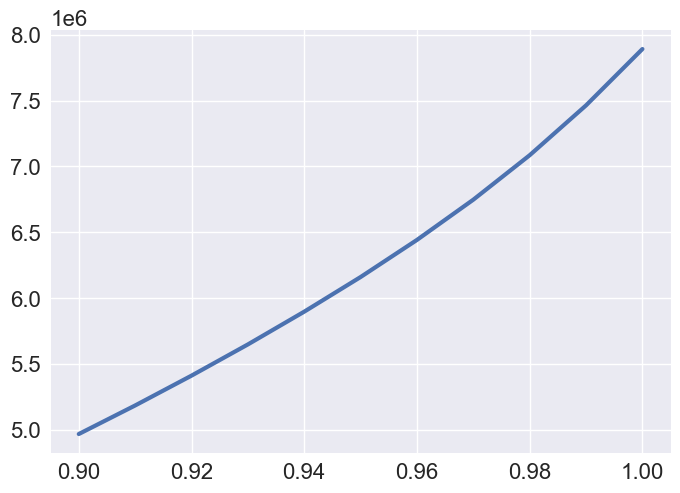

In [ ]:
# Put it all together into one loop 


input_path = r'C:\Users\jpsta\code\energy-modeling\data\storage_model_inputs.xlsx'  # Short data for testing
# input_path = r"C:\Users\jpsta\data\grid_data\storage_model_inputs.xlsx"  # Long data -- store in a local folder (Github doesn't like large files)

# Decide where to store the output files
output_folder = r"C:\Users\jpsta\data\grid_data\outputs"
run_start = datetime.now()  # This will be a label for the output file

# Load inputs
input_ts = pd.read_excel(input_path, sheet_name='Time-Series Data', parse_dates=['INTERVAL_START'])
input_scalar = pd.read_excel(input_path, sheet_name='Scalar Parameters', skiprows=1)

# Run the loop
ops_npvs = []
writer = pd.ExcelWriter(os.path.join(output_folder, f"model_run_{run_start.strftime('%Y-%m-%d_%H%M%S')}.xlsx"))
for n in range(len(input_scalar)):
    row = input_scalar.iloc[[n],:]
    # Create and solve model
    m, results = battery_model(input_ts, row)

    # Extract results
    df_results, npv_operating_profit, daily_finances = extract_results(m, input_ts, row)

    # Record data
    ops_npvs.append(npv_operating_profit)
    daily_finances = daily_finances.reset_index()
    daily_finances['time (hours)'] = daily_finances['time (hours)'].dt.tz_localize(None)
    daily_finances.to_excel(writer, sheet_name=str(row['Scenario'].iloc[0]))

writer.close()
# Organize the data
profits = input_scalar.copy()
profits['NPV of Operating Profit ($)'] = ops_npvs

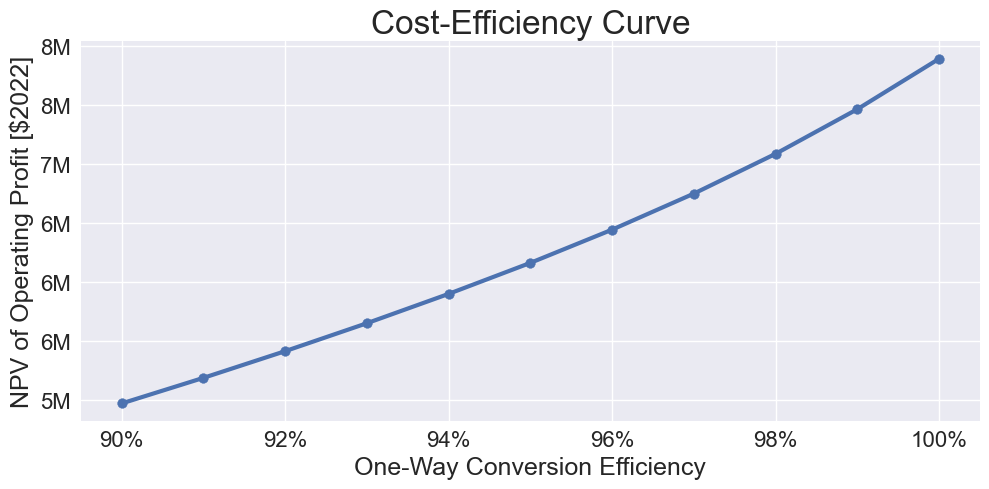

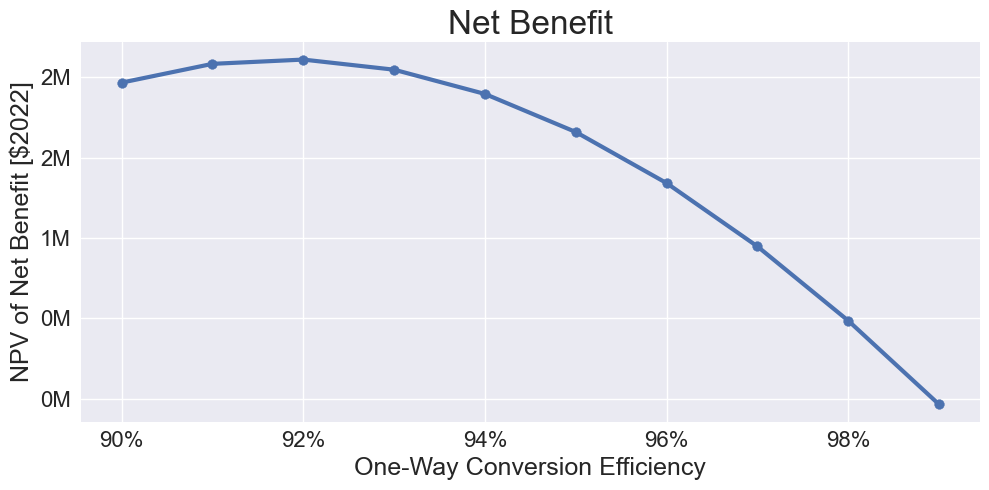

In [46]:
# Explore results 


profits = input_scalar.copy()
profits['NPV of Operating Profit ($)'] = ops_npvs
graph_df = profits.copy()
inverter_curve = pd.read_excel(input_path, sheet_name="Inverter Options")


plt.figure(figsize=(10,5))
plt.plot(graph_df['One-Way Conversion Efficiency (%)'], graph_df['NPV of Operating Profit ($)'] / 10**6)
plt.scatter(graph_df['One-Way Conversion Efficiency (%)'], graph_df['NPV of Operating Profit ($)'] / 10**6)
plt.xlabel('One-Way Conversion Efficiency')
plt.ylabel('NPV of Operating Profit [$2022]')
plt.title('Cost-Efficiency Curve')
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}M'))
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'cost-efficiency.png'), dpi=200)



## Explore marginal benefit of efficiency gains



graph_df['Marginal Benefit'] = graph_df['NPV of Operating Profit ($)'].diff()

## Graph to show marginal benefit
# plt.figure(figsize=(10,5))
# plt.plot(graph_df['One-Way Conversion Efficiency (%)'], graph_df['Marginal Benefit']/10**3, label='Marginal Benefit of Efficiency Gain')
# plt.scatter(graph_df['One-Way Conversion Efficiency (%)'], graph_df['Marginal Benefit']/10**3)
# plt.plot(inverter_curve['One-Way Efficiency'], inverter_curve['Cost Difference'] / 10**3, label='Marginal Cost of Efficiency Gain')
# plt.scatter(inverter_curve['One-Way Efficiency'], inverter_curve['Cost Difference'] / 10**3)
# plt.xlabel('One-Way Conversion Efficiency')
# plt.ylabel('Net Present Value [$2022]')
# plt.title('Cost-Efficiency Curve')

# plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}k'))
# plt.legend(fontsize=14)
# plt.savefig(os.path.join(output_folder, 'marginal_cost-efficiency.png'), dpi=200)





## Explore the net benefit
inverter_curve['Profit_NPV'] = inverter_curve['NPV Benefit'] - inverter_curve['Cost']

plt.figure(figsize=(10,5))
plt.plot(inverter_curve['One-Way Efficiency'], inverter_curve['Profit_NPV'] / 10**6)
plt.scatter(inverter_curve['One-Way Efficiency'], inverter_curve['Profit_NPV'] / 10**6)
plt.xlabel('One-Way Conversion Efficiency')
plt.ylabel('NPV of Net Benefit [$2022]')
plt.title('Net Benefit')
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}M'))
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'net_benefit.png'), dpi=200)



In [ ]:
# Sanity checks to explore the data 
df_results['Discharge Power (MW)'].sum() / 60

np.average(df_results['LMP'], weights=df_results['Discharge Power (MW)'])

np.float64(66.4385648882819)

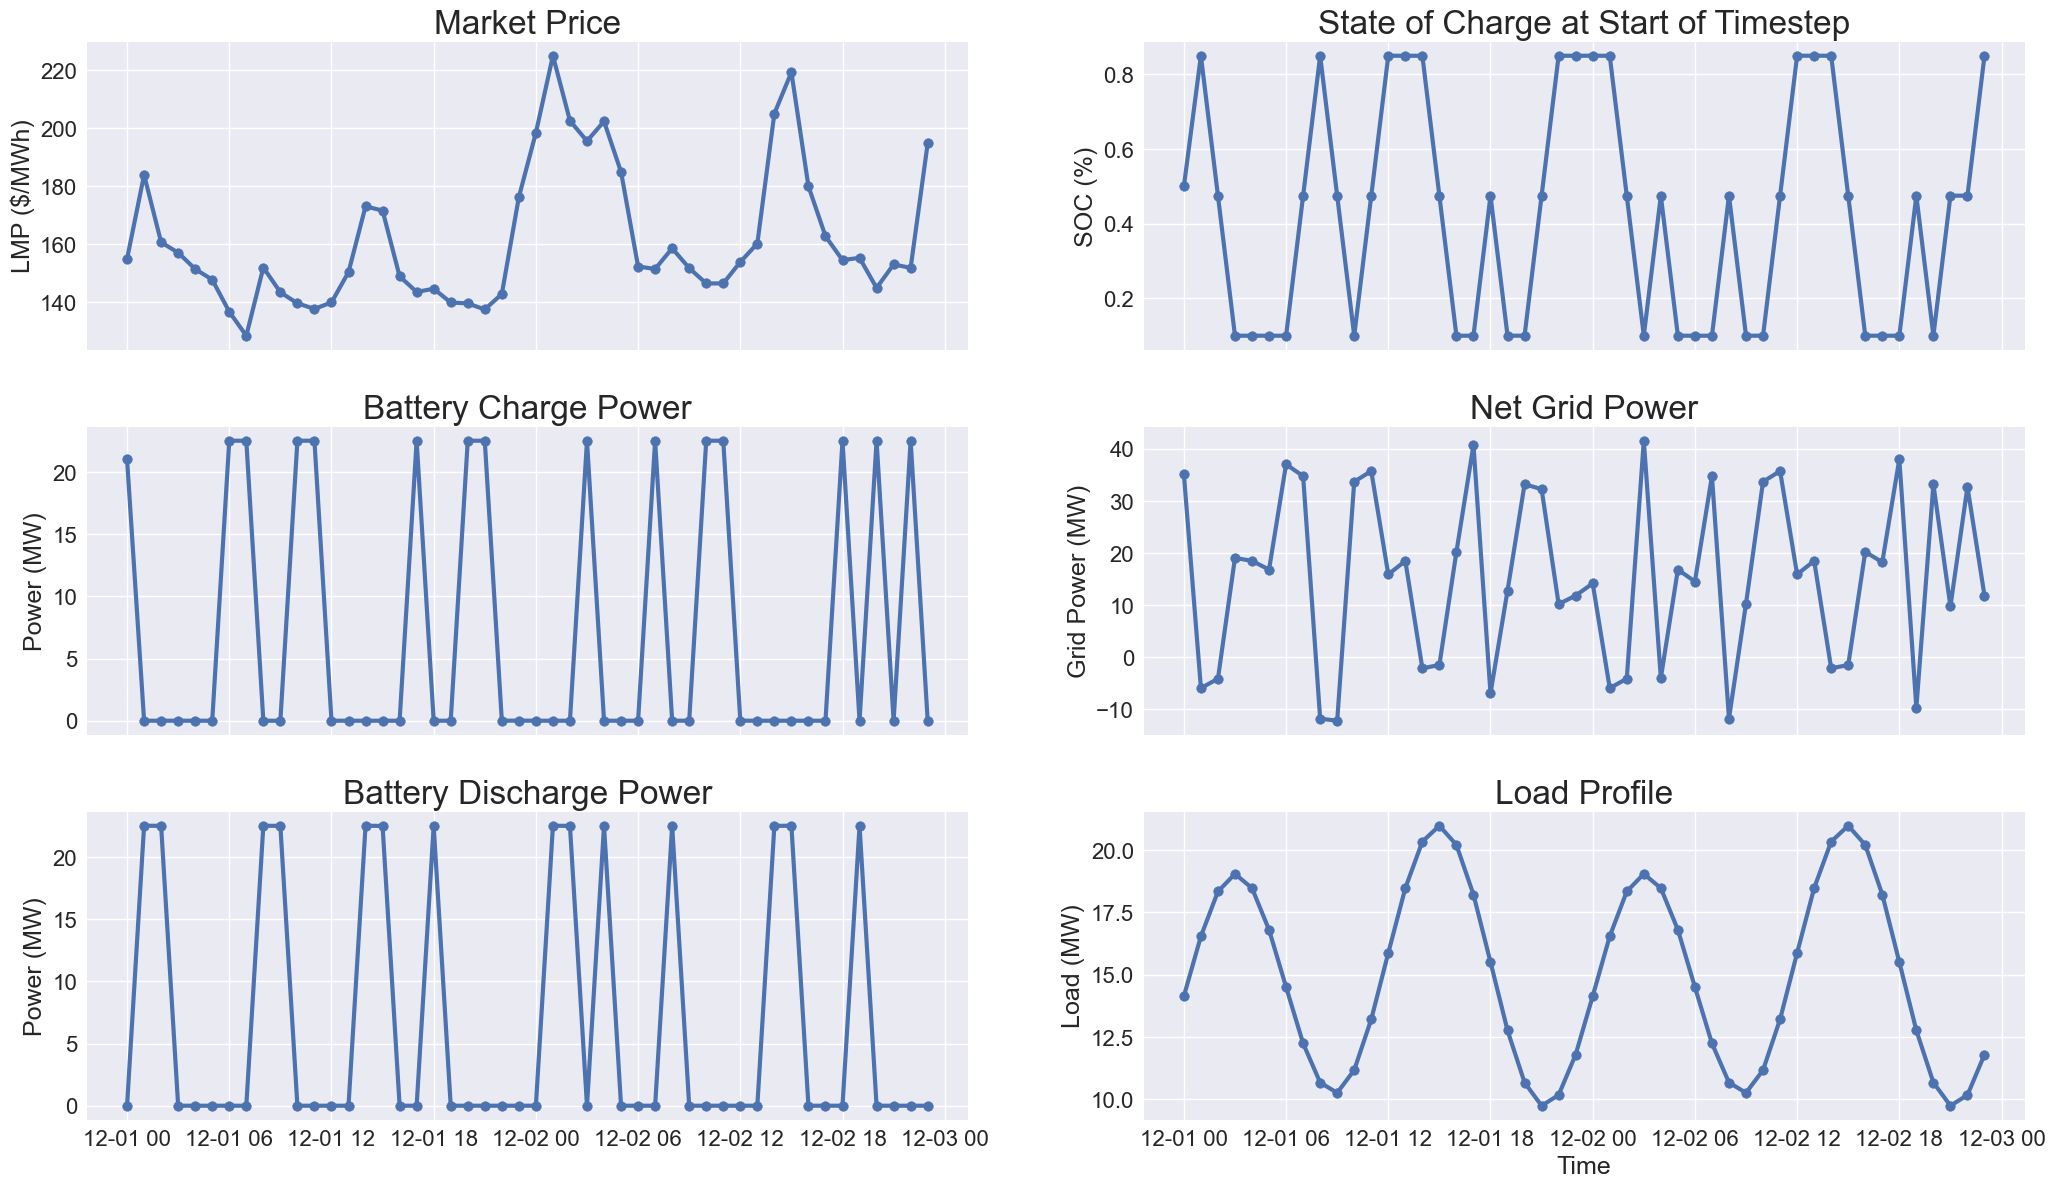

In [56]:
# Sanity Checks 


# Ensure time column is datetime and sorted

# df = df_results[(df_results['time (hours)'] >= pd.to_datetime('2022-12-01')) & (df_results['time (hours)'] < pd.to_datetime('2022-12-01') + pd.Timedelta(days=1))]

df = df_results[df_results["time (hours)"].between("2022-12-01", "2022-12-02 23:59:59")]


df = df.sort_values("time (hours)")
df["time (hours)"] = pd.to_datetime(df["time (hours)"])

fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(25, 14), sharex=True,
    gridspec_kw={"hspace": 0.25}
)

n = 0
# --- 1. Load ---
n=(0,0)
axes[n].plot(df["time (hours)"], df["LMP"])
axes[n].scatter(df["time (hours)"], df["LMP"])
axes[n].set_ylabel("LMP ($/MWh)")
axes[n].set_title("Market Price")


# --- 2. Charge & Discharge Power ---
n=(1,0)
axes[n].plot(df["time (hours)"], df["Charge Power (MW)"], label="Charge")
axes[n].scatter(df["time (hours)"], df["Charge Power (MW)"], label="Charge")
axes[n].set_ylabel("Power (MW)")
axes[n].set_title("Battery Charge Power")

n=(2,0)
axes[n].plot(df["time (hours)"], df["Discharge Power (MW)"], label="Discharge")
axes[n].scatter(df["time (hours)"], df["Discharge Power (MW)"], label="Discharge")
axes[n].set_ylabel("Power (MW)")
axes[n].set_title("Battery Discharge Power")

# --- 3. Grid Power ---
n=(0,1)
axes[n].plot(df["time (hours)"], df["SOC (%)"])
axes[n].scatter(df["time (hours)"], df["SOC (%)"])
axes[n].set_ylabel("SOC (%)")
axes[n].set_title("State of Charge at Start of Timestep")


# --- 4. SOC ---
n=(1,1)
axes[n].plot(df["time (hours)"], df["Grid Power (MW)"])
axes[n].scatter(df["time (hours)"], df["Grid Power (MW)"])
axes[n].set_ylabel("Grid Power (MW)")
axes[n].set_title("Net Grid Power")

# --- 5. Market Price ---
n = (2,1)
axes[n].plot(df["time (hours)"], df["load"])
axes[n].scatter(df["time (hours)"], df["load"])
axes[n].set_ylabel("Load (MW)")
axes[n].set_title("Load Profile")
axes[n].set_xlabel("Time")

plt.minorticks_on()

plt.show()


## PyPSA Modeling

Exploring PyPSA functionality to see if it can be useful. This code is older; use with caution!

Network: 
* Load (Constant for datacenter)
* Grid connection (constant generator with a specific marginal cost)
* Storage (of a specific size)
* Generator for solar power 



In [ ]:
import requests
import pandas as pd
from io import BytesIO
from zipfile import ZipFile

def fetch_caiso_lmp(node, start_date, end_date):
    """
    Fetch CAISO day-ahead nodal LMPs from OASIS and normalize schema.

    Parameters
    ----------
    node : str
        CAISO PNode name, e.g. "TH_N001"
    start_date : str
        Start datetime in format YYYYMMDDT00:00-0000
    end_date : str
        End datetime in format YYYYMMDDT00:00-0000

    Returns
    -------
    pandas.DataFrame
        Tidy dataframe with columns:
        interval_start, node, LMP, MCE, MCC, MCL
    """

    # node = "119TH_BP_LNODEXF1"
    # start_date = "20251206T00:00-0000"
    # end_date   = "20251207T00:00-0000"

    base_url = "http://oasis.caiso.com/oasisapi/SingleZip"

    params = {
        "queryname": "PRC_LMP",
        "market_run_id": "DAM",
        "node": node,
        "startdatetime": start_date,
        "enddatetime": end_date,
        "resultformat": 6,  # Produces CSV instead of XML
        "version": 12  # Confirmed to work with v12; not sure about others
    }

    print(f"Requesting data for node {node}...")
    response = requests.get(base_url, params=params)

    if response.status_code != 200:
        raise RuntimeError(f"Failed request: {response.status_code}")

    # Unzip the returned file
    with ZipFile(BytesIO(response.content)) as z:
        csv_filename = z.namelist()[0]
        with z.open(csv_filename) as f:
            df = pd.read_csv(f)

    # Normalize column names
    df.columns = df.columns.str.upper()

    # Detect schema
    schema_a = "LMP" in df.columns  # older schema
    schema_b = "MW" in df.columns   # newer schema

    if schema_a:
        # Schema A: LMP, MCE, MCC, MCL already present
        df["VALUE"] = df["LMP"]

    elif schema_b:
        # Schema B: MW column contains the numeric value
        df["VALUE"] = df["MW"]

    else:
        raise ValueError("Unrecognized CAISO PRC_LMP schema. No LMP or MW column found.")

    # Standardize timestamp column names
    time_cols = [c for c in df.columns if "INTERVALSTART" in c]
    if time_cols:
        df["INTERVAL_START"] = pd.to_datetime(df[time_cols[0]])
    else:
        raise ValueError("Could not find interval start time column.")

    # Standardize node column
    if "NODE" not in df.columns:
        raise ValueError("NODE column missing from PRC_LMP file.")

    # Pivot into wide format
    df_pivot = df.pivot_table(
        index=["INTERVAL_START", "NODE"],
        columns="LMP_TYPE",
        values="VALUE"
    ).reset_index()

    # Ensure all expected columns exist
    for col in ["LMP", "MCE", "MCC", "MCL"]:
        if col not in df_pivot.columns:
            df_pivot[col] = None

    return df_pivot


# -------------------------
# Example usage
# -------------------------

node = "TH_NP15_GEN-APND"
start = "20251201T00:00-0000"
end   = "20251207T00:00-0000"

LMP_data = fetch_caiso_lmp(node, start, end)
print(LMP_data.head())


Requesting data for node TH_NP15_GEN-APND...
LMP_TYPE            INTERVAL_START              NODE       LMP      MCC  \
0        2025-12-01 00:00:00+00:00  TH_NP15_GEN-APND  61.89777  6.22486   
1        2025-12-01 01:00:00+00:00  TH_NP15_GEN-APND  64.75052  5.81237   
2        2025-12-01 02:00:00+00:00  TH_NP15_GEN-APND  64.79987  5.17822   
3        2025-12-01 03:00:00+00:00  TH_NP15_GEN-APND  59.71932  2.69332   
4        2025-12-01 04:00:00+00:00  TH_NP15_GEN-APND  54.07210 -0.24510   

LMP_TYPE       MCE      MCL  MGHG  
0         55.20915  0.46376   0.0  
1         57.99286  0.94528   0.0  
2         58.14477  1.47688   0.0  
3         55.59173  1.43427   0.0  
4         53.05968  1.25751   0.0  


In [ ]:
px.scatter(LMP_data, x="INTERVAL_START", y="LMP", title="LMP Over Time")

Text(0.5, 1.0, 'Daily Solar Power Profile')

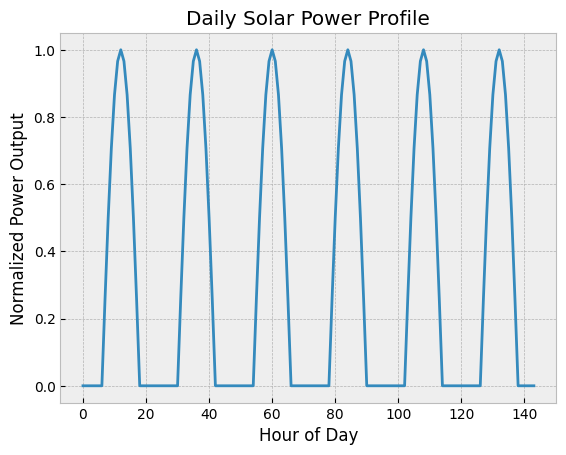

In [ ]:
# Create the solar power profile. 

# Sunrise at 6 AM, Sunset at 6 PM, peak at noon. 

num_steps = len(LMP_data)

solar_profile = np.zeros(num_steps)
for hour in range(num_steps):
    if hour % 24 > 6 and hour % 24 < 18:        
        solar_profile[hour] = np.sin(np.pi * (hour - 6) / 12)

plt.plot(range(num_steps), solar_profile)
plt.xlabel("Hour of Day")
plt.ylabel('Normalized Power Output')
plt.title("Daily Solar Power Profile")

Text(0, 0.5, 'Load (MW)')

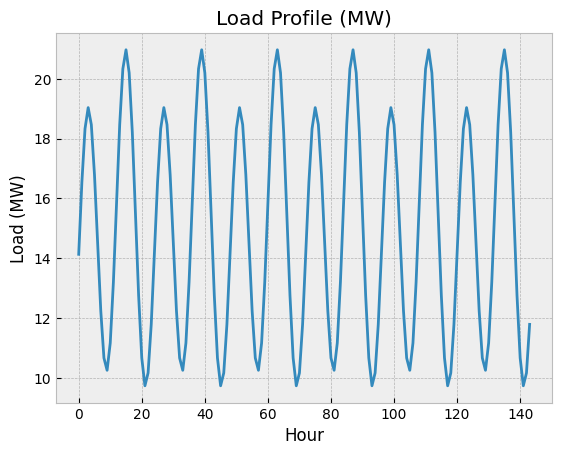

In [ ]:
# Now it's time to come up with the load profile! It's not actually constant. 
# I couldn't find a good source for a realistic datacenter load profile, but I did see 
# a couple sources saying it's fairly constant with some variation based on cooling load. 

# Assume hourly data

load_IT_const = 15  # MW
load_IT_variation = 5  # MW (this will vary sinusoidally)
load_cooling = 1  # MW (this will peak in the middle of the day)

num_steps = len(LMP_data)
x = np.arange(num_steps)

load_profile = np.ones(num_steps) * load_IT_const + load_IT_variation * np.sin(4 * np.pi * x / 24) + load_cooling * np.sin(2 * np.pi * (x - 8) / 24)  # Base load in MW

plt.plot(range(num_steps), load_profile)
plt.title('Load Profile (MW)')
plt.xlabel('Hour')
plt.ylabel('Load (MW)')

In [ ]:
# Create a Network for modeling and provide a fake load time series

# For the purpose of this notebook, all power units will be in MW. We ignore AC/DC, voltage levels, etc for now. 

# Create network
n1 = pypsa.Network(Name="Battery")

# Set snapshots. Each snapshot is one time step in the simulation
# Here we create 24 snapshots to simulate one day with hourly resolution
n1.set_snapshots(range(num_steps))

# Define the carrier type
n1.add("Carrier", "electricity")


# Create the bus where components will be connected
n1.add("Bus", "Datacenter", carrier="electricity")


# Add the load
n1.add(
    "Load",
    "Datacenter",
    carrier="electricity",
    bus="Datacenter",
    p_set=load_profile
)

# Add a storage unit (battery)
# Parameters are fake for now
n1.add(
    "StorageUnit",
    "Datacenter",
    carrier="electricity",
    bus="Datacenter",
    p_nom=100,
    max_hours=4,
    efficiency_store=0.95,
    efficiency_dispatch=0.95,
    standing_loss=0.001   # % losses per hour (loss to state of charge)
)

# Add a generator with the above solar profile
n1.add(
    "Generator",
    "Solar",
    carrier="electricity",
    bus="Datacenter",
    p_nom=50,
    p_max_pu=solar_profile
)

# Add a "generator" to simulate grid power
n1.add(
    "Generator",
    "Grid",
    carrier="electricity",
    bus="Datacenter",
    p_nom=1000,
    marginal_cost=LMP_data['LMP']  # Cost per MWh
)


In [ ]:
# Run optimization
start = datetime.now()
n1.optimize()
end = datetime.now()
print(f"Optimization took: {end - start}")

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.11s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1728 duals
Objective: 7.75e+03
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Optimization took: 0:00:00.791093


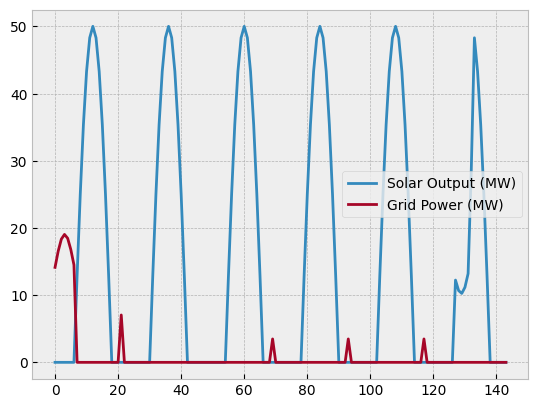

In [ ]:
# Examine output! 

n1.generators_t.p

plt.figure()
plt.plot(n1.snapshots, n1.generators_t.p['Solar'], label='Solar Output (MW)')
plt.plot(n1.snapshots, n1.generators_t.p['Grid'], label='Grid Power (MW)')
plt.legend()

In [ ]:
# Create a pandas DataFrame to summarize results 

def summarize_results(network):
    results = pd.DataFrame(index=network.snapshots)
    
    # Add generator outputs
    for gen in network.generators.index:
        results[f'{gen}_Output_MW'] = network.generators_t.p[gen]
    
    # Add storage unit state of charge
    for su in network.storage_units.index:
        results[f'{su}_SoC_MWh'] = network.storage_units_t.state_of_charge[su]
    
    # Add load
    for load in network.loads.index:
        results[f'Load_{load}_MW'] = network.loads_t.p[load]
    
    return results

results_df = summarize_results(n1)
results_df

,Solar_Output_MW,Grid_Output_MW,Datacenter_SoC_MWh,Load_Datacenter_MW
snapshot,,,,
0,-0.0,14.133975,-0.000000,14.133975
1,-0.0,16.534074,-0.000000,16.534074
2,-0.0,18.330127,-0.000000,18.330127
3,-0.0,19.034074,-0.000000,19.034074
4,-0.0,18.464102,-0.000000,18.464102
...,...,...,...,...
139,-0.0,-0.000000,44.717761,12.758819
140,-0.0,-0.000000,33.441598,10.669873
141,-0.0,-0.000000,23.154282,9.741181


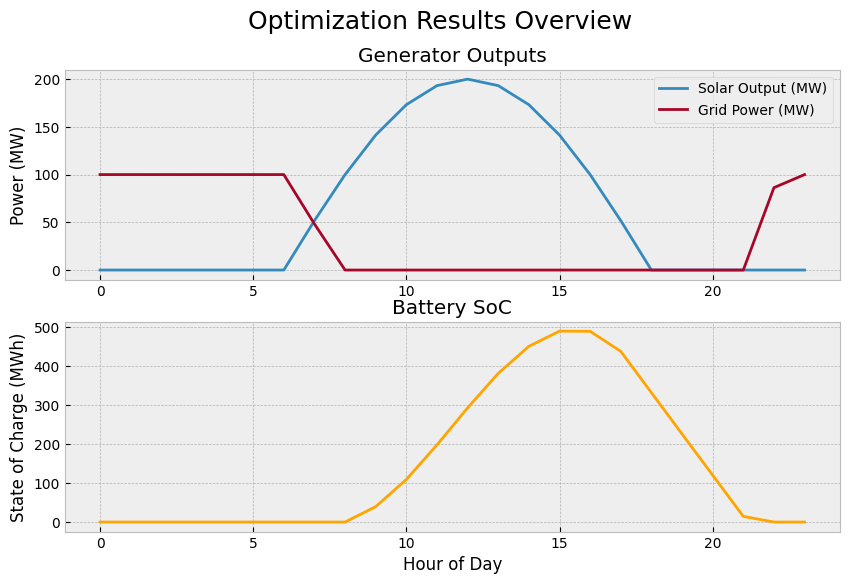

: 

In [ ]:
# Visualizing the curves

fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot(211)
plt.plot(n1.snapshots, n1.generators_t.p['Solar'], label='Solar Output (MW)')
plt.plot(n1.snapshots, n1.generators_t.p['Grid'], label='Grid Power (MW)')
plt.ylabel('Power (MW)')
plt.legend()
plt.title('Generator Outputs')

plt.subplot(212, sharex=ax1)
plt.plot(results_df.index, results_df['Datacenter_SoC_MWh'], label="Battery State of Charge (MWh)", color='orange')
plt.xlabel('Hour of Day')
plt.ylabel('State of Charge (MWh)')
plt.title('Battery SoC')
fig.suptitle('Optimization Results Overview', fontsize=18)

plt.show()


In [ ]:
fig = px.scatter(results_df, y=['Solar_Output_MW', 'Grid_Output_MW'], title='Generator Outputs Over Time')
fig.update_layout(
    yaxis_title='Power (MW)', 
    xaxis_title='Time Step', 
    width=800, 
    font=dict(size=18)
)

In [ ]:
n1.components.generators.defaults 

,type,unit,default,description,status,static,varying,typ,dtype
attribute,,,,,,,,,
name,string,NaN,,Unique name,Input (required),True,False,<class 'str'>,object
bus,string,NaN,,Name of bus to which generator is attached,Input (required),True,False,<class 'str'>,object
control,string,NaN,PQ,"P,Q,V control strategy for power flow, must be...",Input (optional),True,False,<class 'str'>,object
type,string,NaN,,Placeholder for generator type. Not implemented.,Input (optional),True,False,<class 'str'>,object
p_nom,float,MW,0.0,Nominal power for limits on `p` in optimizati...,Input (optional),True,False,<class 'float'>,float64
p_nom_mod,float,MW,0.0,Nominal power of the generator module (e.g. fi...,Input (optional),True,False,<class 'float'>,float64
p_nom_extendable,boolean,NaN,False,Switch to allow capacity `p_nom` to be extende...,Input (optional),True,False,<class 'bool'>,bool
p_nom_min,float,MW,0.0,"If `p_nom` is extendable in optimization, set ...",Input (optional),True,False,<class 'float'>,float64
p_nom_max,float,MW,inf,"If `p_nom` is extendable in optimization, set ...",Input (optional),True,False,<class 'float'>,float64
